### Load up the data and format it

In [3]:
import pandas as pd
from dateutil import parser
from datetime import datetime
import pytz

# Load data
articles = pd.read_csv("../../data/processed/gbh_geocoded_output.csv")
demographics = pd.read_csv("../../data/processed/demographics_by_tract.csv")

# Drop unnecessary columns from demographics
demographics = demographics.drop(columns=["Index", "Name", "State", "County"])

# Drop rows without neighborhoods
articles.dropna(subset=["Neighborhood"], inplace=True)

# Dictionary to map timezone names to pytz time zones
tzinfos = {'EST': pytz.timezone('US/Eastern'), 'EDT': pytz.timezone('US/Eastern')}

# Function to convert date strings to datetime objects
def convert_to_datetime(date_str):
    return parser.parse(date_str, tzinfos=tzinfos)

# Apply the conversion function to the 'Publication Date' column
articles['Publication Date'] = articles['Publication Date'].apply(convert_to_datetime)

# Ensure the Publication Date column is timezone-aware
articles['Publication Date'] = articles['Publication Date'].dt.tz_convert(pytz.timezone('US/Eastern'))

### Filter on the appropriate month

In [4]:
# Define the date range (example)
start_date = pytz.timezone('US/Eastern').localize(datetime(2023, 3, 1)) # This is the month with most published articles on the given data set
end_date = pytz.timezone('US/Eastern').localize(datetime(2023, 4, 1))

# Filter the DataFrame for the date range
filtered_articles = articles[(articles['Publication Date'] >= start_date) & (articles['Publication Date'] <= end_date)]

print(f"Using articles from {start_date.date()} to {end_date.date()}")


Using articles from 2023-03-01 to 2023-04-01


### Include demographics data

In [5]:
# Function to merge articles with demographics
def merge_articles_with_demographics(articles_df, demographics_df):
    merged_df = pd.merge(articles_df, demographics_df, on='Census Tract', how='left')
    return merged_df

merged_articles = merge_articles_with_demographics(filtered_articles, demographics)

### Get top neighborhoods

In [6]:
# Function to get the top 5 category based on the number of articles
def get_top_count(data, column):
    count = data[column].value_counts()
    top_count = count.head(5)
    top_count_df = top_count.reset_index()
    top_count_df.columns = [column, "Article Count"]
    return top_count_df

# Count articles by Neighborhood
top_neighborhoods = get_top_count(merged_articles, "Neighborhood")
print("Top 5 Most Frequented Neighborhoods:\n", top_neighborhoods.to_string(index=False))

Top 5 Most Frequented Neighborhoods:
 Neighborhood  Article Count
    Downtown             42
 Beacon Hill             12
      Fenway             11
    Back Bay              8
South Boston              6


### Calculate the Percentage of Articles by Neighborhood to the Total Number of Articles

In [7]:
import plotly.express as px

# Add a row for "Other Neighborhoods"
total_articles = merged_articles["Neighborhood"].value_counts().sum()
other_articles = total_articles - top_neighborhoods["Article Count"].sum()

# Create a DataFrame for "Other Neighborhoods"
other_neighborhoods_df = pd.DataFrame({"Neighborhood": ["Other Neighborhoods"], "Article Count": [other_articles]})

# Concatenate the DataFrames
top_neighborhoods = pd.concat([top_neighborhoods, other_neighborhoods_df], ignore_index=True)

# Create a pie chart using plotly
fig = px.pie(top_neighborhoods, names='Neighborhood', values='Article Count', title='Article Distribution by Neighborhood')
fig.update_layout(width=800, height=600)
fig.show()

### Get Neighborhood Statistics

In [8]:
# Get topic distribution
def get_topic_distribution(df, name, demographic):
    return df[df[name] == demographic]["Closest Topic"].value_counts()

# Article count by neighborhood
def get_article_count_by_neighborhood(df):
    return df["Neighborhood"].value_counts()

# Census tracts related
def get_census_tracts(df, neighborhood):
    return df[df["Neighborhood"] == neighborhood]["Census Tract"].value_counts()

# Get race distribution for a given neighborhood
def get_race_distribution(df, neighborhood):
    neighborhood_data = df[df['Neighborhood'] == neighborhood]
    race_distribution = neighborhood_data[['White', 'African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Island', 'Other']].sum()
    total_population = race_distribution.sum()
    race_distribution_percentage = round((race_distribution *100/ total_population), 2)

    # Convert the dictionary to a DataFrame
    neighborhood_demographics_df = pd.DataFrame(list(race_distribution_percentage.items()), columns=['Race', 'Population'])

    return neighborhood_demographics_df

# Calculate statistics for a given neighborhood
def get_neighborhood_stats(df, neighborhood):
    topic_distribution = get_topic_distribution(df, "Neighborhood", neighborhood)
    article_count = get_article_count_by_neighborhood(df)[neighborhood]
    census_tracts = get_census_tracts(df, neighborhood)
    race_distribution = get_race_distribution(df, neighborhood)
    
    return {
        "Topic Distribution": topic_distribution,
        "Topic Count": len(topic_distribution),
        "Article Count": article_count,
        "Census Tracts": census_tracts,
        "Race Distribution": race_distribution.reset_index(drop=True)
    }

### Get Boston statistics and Compare them with the neighborhood statistics

In [9]:
# Boston demographics https://www.census.gov/quickfacts/fact/table/bostoncitymassachusetts/PST045222
# Ignoring Two or More Races and Hispanic poulation
boston_demographics = {"White": 0.5985, "African American": 0.2771, "Asian": 0.1195, "American Indian and Alaska Native": 0.003695, "Native Hawaiian and Other Pacific Island":0.001232, "Other": 0}

# Convert the dictionary to a DataFrame
boston_demographics_df = pd.DataFrame(list(boston_demographics.items()), columns=['Race', 'Population'])
boston_demographics_df = boston_demographics_df.reset_index(drop=True)
boston_demographics_df["Population"] = round(boston_demographics_df["Population"]*100,2)

# Overall Boston statistics
def get_boston_stats(df):
    topic_distribution = df["Closest Topic"].value_counts()
    article_count = len(df)

    return {
        "Topic Distribution": topic_distribution,
        "Article Count": article_count,
        "Race Distribution": boston_demographics_df,
    }

# Compare neighborhood to Boston
def compare_neighborhood_to_boston(neighborhood_stats, boston_stats):
    comparison = {
        "Neighborhood Article %": round(100*neighborhood_stats["Article Count"] / boston_stats["Article Count"],0),
        "Neighborhood Topic %": round(100*(neighborhood_stats["Topic Distribution"] / neighborhood_stats["Article Count"]),2),
        "Boston Topic %": round(100*(boston_stats["Topic Distribution"] / boston_stats["Article Count"]),2),
        "Neighborhood Race %": neighborhood_stats["Race Distribution"],
        "Boston Race %": boston_stats["Race Distribution"]

    }
    
    return comparison


### Collect Statistics

In [10]:
# Example: Get stats for a specific neighborhood
neighborhood = "Downtown"
neighborhood_stats = get_neighborhood_stats(merged_articles, neighborhood)

# Get Boston stats
boston_stats = get_boston_stats(filtered_articles)

# Compare neighborhood to Boston
comparison = compare_neighborhood_to_boston(neighborhood_stats, boston_stats)

### Visualize Comparisons

C:\Users\axel0\AppData\Local\Temp\ipykernel_25068\309685580.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




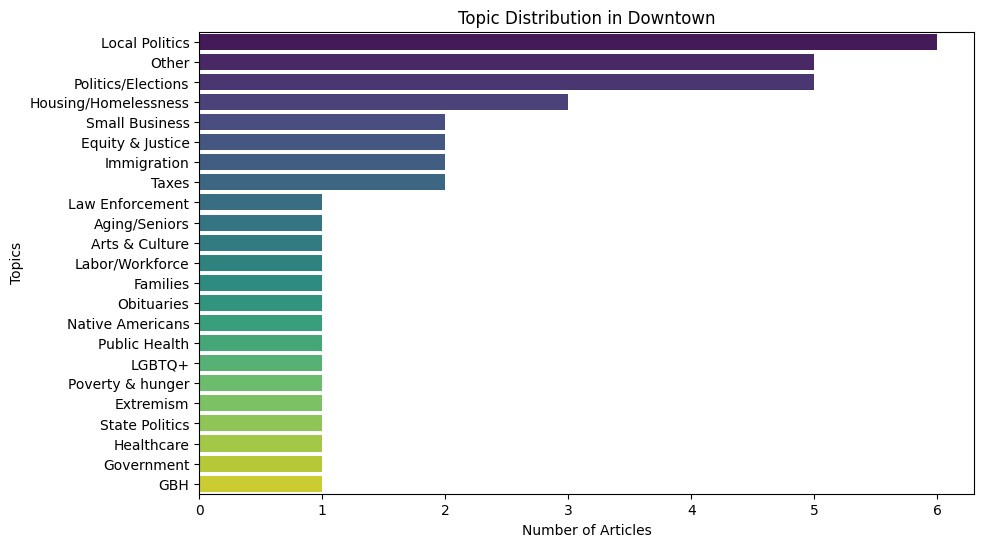

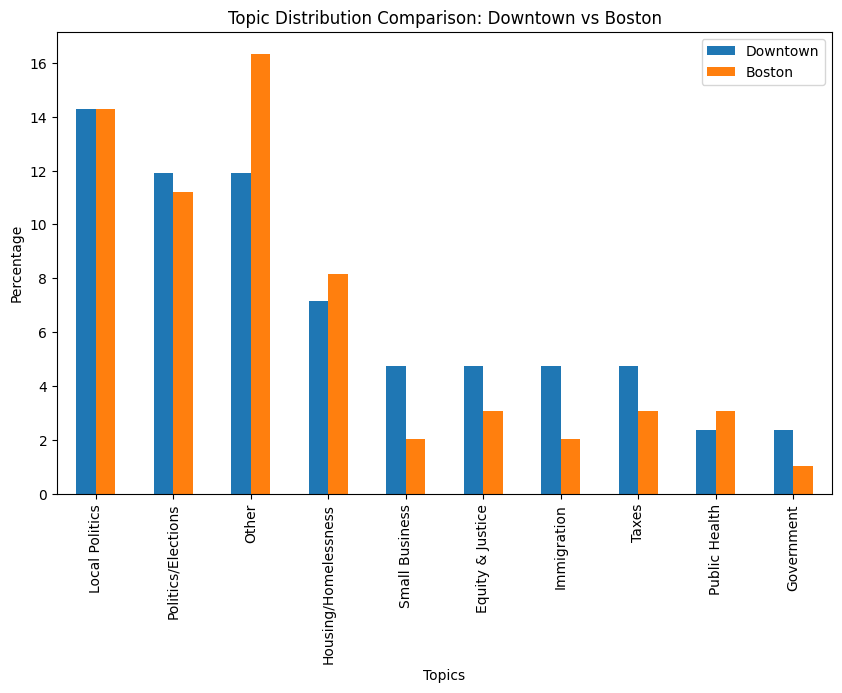

<Figure size 1200x600 with 0 Axes>

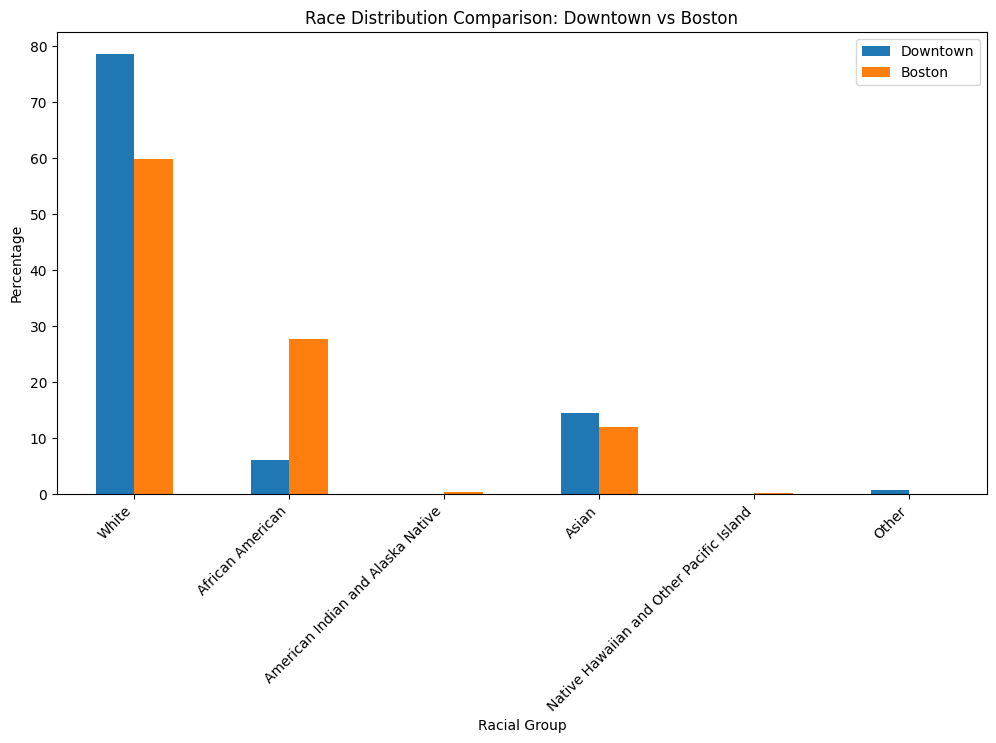

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize topic distribution for the neighborhood
plt.figure(figsize=(10, 6))
sns.barplot(x=neighborhood_stats["Topic Distribution"].values, y=neighborhood_stats["Topic Distribution"].index, palette="viridis")
plt.xlabel("Number of Articles")
plt.ylabel("Topics")
plt.title(f"Topic Distribution in {neighborhood}")
plt.show()

import plotly.graph_objects as go

percentage = comparison["Neighborhood Article %"]

# Data for the pie chart
labels = ['Other Neighborhoods', neighborhood]
values = [neighborhood_stats["Article Count"], boston_stats["Article Count"] - neighborhood_stats["Article Count"]]

# Pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(
    title_text=f'Percentage of Articles in Boston from {neighborhood}',
)
fig.show()

# Get the top 10 topics for the neighborhood
top_neighborhood_topics = comparison["Neighborhood Topic %"].sort_values(ascending=False).head(10)

# Filter Boston's topics to match the top 10 neighborhood topics
boston_topics_filtered = comparison["Boston Topic %"].reindex(top_neighborhood_topics.index)

# Visualize comparison of topic distribution
comparison_df = pd.DataFrame({
    neighborhood: top_neighborhood_topics,
    "Boston": boston_topics_filtered
})

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel("Topics")
plt.ylabel("Percentage")
plt.title(f"Topic Distribution Comparison: {neighborhood} vs Boston")
plt.show()

# Ensure race distributions are in the same format
neighborhood_race_dist = comparison["Neighborhood Race %"].set_index("Race")
boston_race_dist = comparison["Boston Race %"].set_index("Race")

# Combine neighborhood and Boston race distributions into a DataFrame
race_comparison_df = pd.concat([neighborhood_race_dist, boston_race_dist], axis=1)
race_comparison_df.columns = [neighborhood, "Boston"]

# Plot the race distribution comparison
plt.figure(figsize=(12, 6))
race_comparison_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel("Racial Group")
plt.ylabel("Percentage")
plt.title(f"Race Distribution Comparison: {neighborhood} vs Boston")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()

import plotly.express as px
# Pie chart for Race distribution for the top neighborhood
fig = px.pie(neighborhood_stats["Race Distribution"], names=neighborhood_stats["Race Distribution"]["Race"], values="Population", title=f'{neighborhood} Race Distribution')
fig.update_layout(width=800, height=600)
fig.show()

# Show census tracts and graph of top 5 census tracts
# Show graph of race distribution